In [25]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

In [26]:
# READ IN AUDIO FILES 
audio = "E:\Datasets\RAVDESS/audio_speech_actors_01-24/"

In [38]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df = pd.read_csv('ravdess.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...
1,male,neutral,1,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...
2,male,neutral,1,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...
3,male,neutral,1,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...
4,male,calm,1,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...


In [39]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [40]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


In [41]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

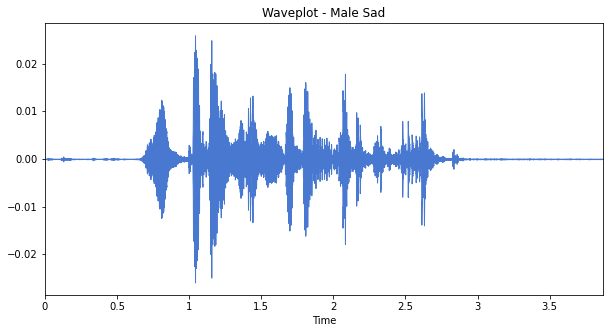

In [42]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')

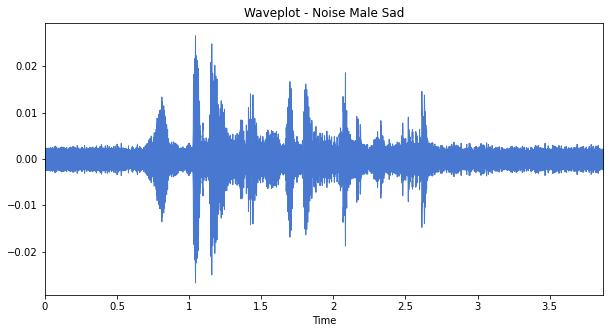

In [43]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')

In [44]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

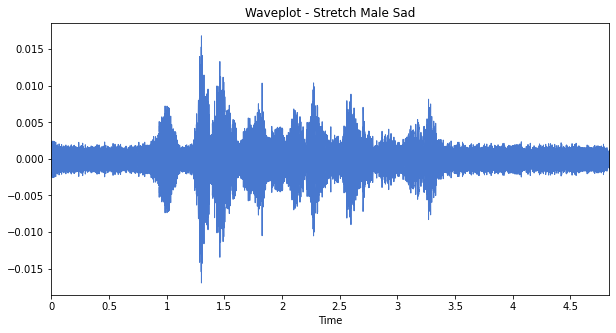

In [45]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [46]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

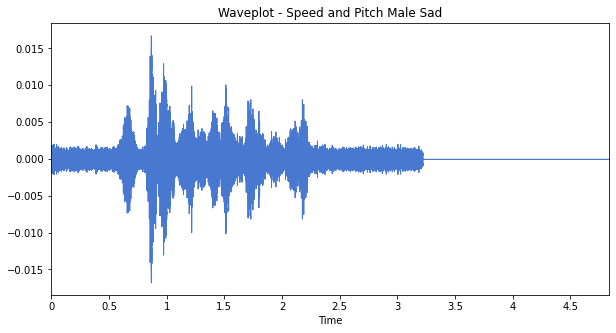

In [47]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [48]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-52.010284, -52.010284, -52.010284, -52.01028..."
1,"[-67.44706, -67.421036, -67.53507, -67.25538, ..."
2,"[-68.620384, -68.49013, -68.54058, -68.60243, ..."
3,"[-45.19984, -43.82312, -44.344078, -45.735817,..."
4,"[-60.652348, -60.72612, -60.604263, -60.55492,..."


In [49]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-52.010284, -52.010284, -52.010284, -52.01028..."
1,"[-67.44706, -67.421036, -67.53507, -67.25538, ..."
2,"[-68.620384, -68.49013, -68.54058, -68.60243, ..."
3,"[-45.19984, -43.82312, -44.344078, -45.735817,..."
4,"[-60.652348, -60.72612, -60.604263, -60.55492,..."


In [50]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-54.842808, -54.842808, -54.842808, -54.84280..."
1,"[-68.91656, -69.007545, -68.73131, -68.72158, ..."
2,"[-69.38673, -69.39867, -69.57351, -69.71819, -..."
3,"[-47.32301, -46.75488, -48.497635, -48.10561, ..."
4,"[-60.81163, -60.674088, -60.697956, -60.7531, ..."


In [51]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))

1152


In [52]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [53]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [54]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [55]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [56]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [57]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-55.350864,-54.635700,-54.561180,-55.446121,-55.953434,-56.111580,-56.143040,-56.143040,-56.092976,-56.070923,...,-55.757290,-55.860142,-55.975815,-55.939114,-56.025181,-55.984623,-56.052174,-56.140205,-56.143040,angry
4604,-67.904999,-67.943665,-68.031281,-67.961525,-67.885712,-68.044617,-68.102264,-68.009331,-67.908081,-67.852127,...,-67.771706,-67.718842,-67.534889,-67.411179,-67.642990,-67.714569,-67.876793,-67.729774,-67.574707,sad
4605,-76.469704,-76.469704,-76.469704,-76.469704,-76.469704,-76.051636,-76.397690,-76.469704,-76.469704,-76.469704,...,-76.464203,-76.469704,-76.469704,-76.469704,-76.469704,-76.469704,-76.469704,-76.469704,-76.469704,sad
4606,-82.734825,-79.602737,-77.126938,-76.456169,-77.006424,-76.750793,-76.038513,-75.667809,-75.560844,-76.109756,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4607,-70.372475,-70.616646,-70.727432,-70.727432,-70.727432,-70.671021,-70.727432,-70.727432,-70.727432,-70.727432,...,-67.049797,-67.557854,-67.729691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fear


In [58]:
mfcc.shape

(1152, 260)

In [59]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

In [60]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-52.76322, -52.76322, -52.76322, -52.76322, -..."
1,"[-58.98776, -57.910664, -56.494076, -55.62374,..."
2,"[-52.238705, -52.015965, -51.746494, -51.12382..."
3,"[-52.10011, -52.10011, -52.10011, -52.10011, -..."
4,"[-60.917233, -60.655, -59.86959, -59.600014, -..."


In [61]:
test.reset_index(drop=True,inplace=True)

In [62]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,...,-44.213104,-44.874271,-44.891907,-45.049019,-45.912987,-46.570332,-47.174248,-47.970875,-48.438820,-49.576263
1,male,calm,21,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...,-58.987759,-57.910664,-56.494076,-55.623741,-54.973011,-54.715092,...,-66.325829,-66.646477,-66.721275,-67.368301,-67.622253,-68.267868,-68.893929,-70.283516,-70.107117,-69.970970
2,female,happy,16,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...,-52.100109,-52.100109,-52.100109,-52.100109,-52.100109,-52.100109,...,-51.312187,-51.426300,-51.391220,-51.352646,-51.349068,-51.352383,-51.363049,-51.370937,-51.395046,-51.481194
4,male,fear,23,E:\Datasets\RAVDESS/audio_speech_actors_01-24/...,-60.917233,-60.654999,-59.869591,-59.600014,-59.231213,-59.132954,...,-61.859730,-60.662224,-60.089397,-60.016220,-60.274792,-59.831215,-59.677319,-59.808880,-59.634274,-60.034416


In [63]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,-52.763222,...,-44.213104,-44.874271,-44.891907,-45.049019,-45.912987,-46.570332,-47.174248,-47.970875,-48.438820,-49.576263
1,male,calm,21,-58.987759,-57.910664,-56.494076,-55.623741,-54.973011,-54.715092,-53.624565,...,-66.325829,-66.646477,-66.721275,-67.368301,-67.622253,-68.267868,-68.893929,-70.283516,-70.107117,-69.970970
2,female,happy,16,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,-50.606216,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,-52.100109,-52.100109,-52.100109,-52.100109,-52.100109,-52.100109,-52.100109,...,-51.312187,-51.426300,-51.391220,-51.352646,-51.349068,-51.352383,-51.363049,-51.370937,-51.395046,-51.481194
4,male,fear,23,-60.917233,-60.654999,-59.869591,-59.600014,-59.231213,-59.132954,-58.666348,...,-61.859730,-60.662224,-60.089397,-60.016220,-60.274792,-59.831215,-59.677319,-59.808880,-59.634274,-60.034416


In [64]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

In [65]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [66]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
y_train

array([['angry'],
       ['surprise'],
       ['surprise'],
       ...,
       ['sad'],
       ['calm'],
       ['fear']], dtype=object)

In [68]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [69]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [70]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [71]:
X_train.shape[0]

4608

In [72]:
# BUILD 1D CNN LAYERS
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 240, 64)           1344      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0

In [73]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=20, validation_data=(X_test, y_test),callbacks=checkpoint)

Epoch 1/20
575/576 [============================>.] - ETA: 0s - loss: 2.2997 - accuracy: 0.2883
Epoch 00001: val_loss improved from inf to 1.96916, saving model to face_detector.h15
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 50ms/step - loss: 2.2993 - accuracy: 0.2880 - val_loss: 1.9692 - val_accuracy: 0.3333
Epoch 2/20
576/576 [==============================] - ETA: 0s - loss: 1.8759 - accuracy: 0.3327
Epoch 00002: val_loss improved from 1.96916 to 1.73047, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 28s 48ms/step - loss: 1.8759 - accuracy: 0.3327 - val_loss: 1.7305 - val_accuracy: 0.4132
Epoch 3/20
576/576 [==============================] - ETA: 0s - loss: 1.7078 - accuracy: 0.3743
Epoch 00003: val_loss improved from 1.73047 to 1.64443, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 28s 48ms/step - loss: 1.7078 - accuracy: 0.3743 - val_loss: 1.6444 - val_accuracy: 0.4306
Epoch 4/20
576/576 [==============================] - ETA: 0s - loss: 1.6160 - accuracy: 0.4047
Epoch 00004: val_loss improved from 1.64443 to 1.57021, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 28s 49ms/step - loss: 1.6160 - accuracy: 0.4047 - val_loss: 1.5702 - val_accuracy: 0.4340
Epoch 5/20
576/576 [==============================] - ETA: 0s - loss: 1.5424 - accuracy: 0.4243
Epoch 00005: val_loss improved from 1.57021 to 1.53459, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 51ms/step - loss: 1.5424 - accuracy: 0.4243 - val_loss: 1.5346 - val_accuracy: 0.4583
Epoch 6/20
576/576 [==============================] - ETA: 0s - loss: 1.4743 - accuracy: 0.4395
Epoch 00006: val_loss improved from 1.53459 to 1.45294, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 51ms/step - loss: 1.4743 - accuracy: 0.4395 - val_loss: 1.4529 - val_accuracy: 0.4965
Epoch 7/20
575/576 [============================>.] - ETA: 0s - loss: 1.4075 - accuracy: 0.4783
Epoch 00007: val_loss improved from 1.45294 to 1.44366, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 50ms/step - loss: 1.4072 - accuracy: 0.4783 - val_loss: 1.4437 - val_accuracy: 0.4722
Epoch 8/20
576/576 [==============================] - ETA: 0s - loss: 1.3591 - accuracy: 0.5080
Epoch 00008: val_loss improved from 1.44366 to 1.39384, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 28s 49ms/step - loss: 1.3591 - accuracy: 0.5080 - val_loss: 1.3938 - val_accuracy: 0.5139
Epoch 9/20
576/576 [==============================] - ETA: 0s - loss: 1.2947 - accuracy: 0.5286
Epoch 00009: val_loss improved from 1.39384 to 1.35571, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 50ms/step - loss: 1.2947 - accuracy: 0.5286 - val_loss: 1.3557 - val_accuracy: 0.5069
Epoch 10/20
575/576 [============================>.] - ETA: 0s - loss: 1.2399 - accuracy: 0.5439
Epoch 00010: val_loss improved from 1.35571 to 1.34760, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 29s 50ms/step - loss: 1.2401 - accuracy: 0.5436 - val_loss: 1.3476 - val_accuracy: 0.5556
Epoch 11/20
576/576 [==============================] - ETA: 0s - loss: 1.1878 - accuracy: 0.5686
Epoch 00011: val_loss did not improve from 1.34760
576/576 [==============================] - 24s 42ms/step - loss: 1.1878 - accuracy: 0.5686 - val_loss: 1.3706 - val_accuracy: 0.5521
Epoch 12/20
576/576 [==============================] - ETA: 0s - loss: 1.1459 - accuracy: 0.5812
Epoch 00012: val_loss improved from 1.34760 to 1.33132, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 28s 48ms/step - loss: 1.1459 - accuracy: 0.5812 - val_loss: 1.3313 - val_accuracy: 0.5799
Epoch 13/20
576/576 [==============================] - ETA: 0s - loss: 1.0852 - accuracy: 0.6172
Epoch 00013: val_loss did not improve from 1.33132
576/576 [==============================] - 25s 43ms/step - loss: 1.0852 - accuracy: 0.6172 - val_loss: 1.3522 - val_accuracy: 0.5625
Epoch 14/20
576/576 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.6356
Epoch 00014: val_loss did not improve from 1.33132
576/576 [==============================] - 24s 42ms/step - loss: 1.0525 - accuracy: 0.6356 - val_loss: 1.3643 - val_accuracy: 0.5486
Epoch 15/20
576/576 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.6526
Epoch 00015: val_loss did not improve from 1.33132
576/576 [==============================] - 25s 43ms/step - loss: 1.0053 - accuracy: 0.6526 - val_loss: 1.3562 - val_accuracy: 0.5764
Epoch 16/20
575/576 [===

In [74]:
model.save_weights("ravdess_best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

Saved model to disk


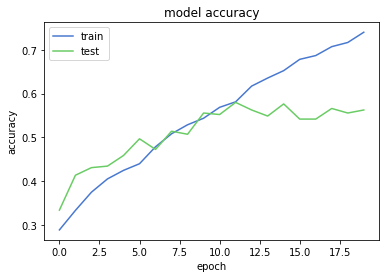

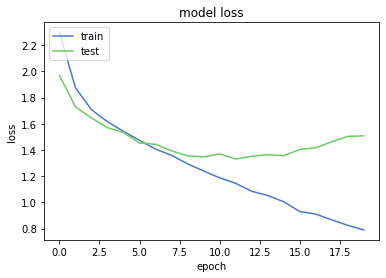

In [75]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [76]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,sad
141,surprise,angry
142,neutral,calm
143,sad,sad
144,fear,surprise
145,sad,sad
146,disgust,disgust
147,angry,angry
148,surprise,surprise
149,angry,surprise


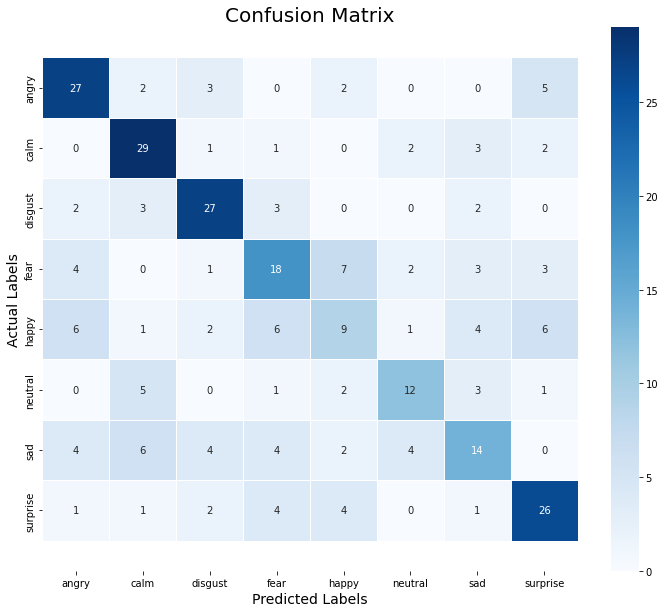

In [77]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [78]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.61      0.69      0.65        39
        calm       0.62      0.76      0.68        38
     disgust       0.68      0.73      0.70        37
        fear       0.49      0.47      0.48        38
       happy       0.35      0.26      0.30        35
     neutral       0.57      0.50      0.53        24
         sad       0.47      0.37      0.41        38
    surprise       0.60      0.67      0.63        39

    accuracy                           0.56       288
   macro avg       0.55      0.56      0.55       288
weighted avg       0.55      0.56      0.55       288

